In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import neurokit2 as nk
import matplotlib.pyplot as plt
import ray
import random
import scipy.stats
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

from src.utils import dataload, ECG_Dataset, seedset

import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

import random
from numpy import argmax
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score, f1_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from src.model import ResNet
from src.stat_function import *

plt.rcParams['axes.unicode_minus'] = False
# plt.style.use('seaborn')
fe = fm.FontEntry(
    fname=r'../tmp/ArialCE.ttf', # ttf 파일이 저장되어 있는 경로
    name='arial')                       
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 20, 'font.family': 'arial'}) 

torch.set_num_threads(64)
tqdm.pandas()

def r2(v):
    return "{:.2f}".format(round(v, 2))
def r3(v):
    return "{:.3f}".format(round(v, 3))
def r4(v):
    return "{:.4f}".format(round(v, 4))

class makeargs:
    bs = 2048
    seed = 54
    disease = 'diabetes'

args = makeargs

# Characteristic

In [2]:
seedset(args.seed)
print("Data Loading Start")
with open('../usedata/traindata/diabetes.pkl', 'rb') as f:
    data = pickle.load(f)
    data['age'] = data['age'].astype(float)
    data = data[data['age'] >= 18]
    data['waveflag'] = data['waveform'].progress_apply(lambda x: 1 if np.isnan(x).sum() == 0 else 0)
    data = data[data['waveflag'] == 1][data.columns.difference(['waveflag'], sort=False)]
    data = data.sort_values(['PT_NO', 'date'])
    data['drank'] = data.groupby(['PT_NO']).cumcount()
    data = data[data['drank'] == 0][data.columns.difference(['drank'], sort=False)]
    args.disease = 'diabetes'

cci = pd.read_csv('../usedata/cci.csv')
def diseaselabel(v):
    if 'E1' in v:
        return 'diabetes'
    elif 'I2' in v:
        return 'MI'
    elif 'I50' in v:
        return 'HF'
    elif 'I7' in v:
        return 'peripheral'
    elif 'I6' in v:
        return 'cerebrovascular'
    elif 'F03' in v or 'G30' in v:
        return 'dementia'
    elif 'J' in v:
        return 'pulmonary'
    elif 'M' in v:
        return 'connective'
    elif 'K2' in v:
        return 'ulcer'
    elif 'B1' in v or 'K7' in v:
        return 'liver'
    elif 'G8' in v:
        return 'plegia'
    elif 'N1' in v:
        return 'renal'
    elif any(f'C{i}' in v for i in range(76, 81)):
        return 'metastatic'
    elif 'C' in v:
        return 'malignancy'
    elif 'B2' in v:
        return 'HIV'

cci = pd.read_csv('/workspace/usedata/cci.csv')
cci['disease'] = cci['ICD10코드'].apply(lambda x: diseaselabel(x))
cci = cci[cci['disease'].notnull()]
cci['cond_date'] = pd.to_datetime(cci['첫 진단일자'])
cci = cci.sort_values(['PT_NO', 'disease', 'cond_date'])
cci['drank'] = cci.groupby(['PT_NO', 'disease']).cumcount()+1
cci = cci[cci['drank'] == 1][cci.columns.difference(['drank'], sort=False)]
ccimerge = pd.merge(data, cci, on='PT_NO', how='left')
ccimerge = ccimerge[ccimerge['disease'].notnull()][['PT_NO', 'date', 'disease', 'cond_date']]
ccimerge['diff'] = (pd.to_datetime(ccimerge['date']) - pd.to_datetime(ccimerge['cond_date'])).dt.days
ccimerge = ccimerge[ccimerge['diff'] > 0]
ds = pd.unique(ccimerge['disease'])

pd.set_option('mode.chained_assignment',  None)
ccidfset = []
for n, pid in tqdm(enumerate(pd.unique(ccimerge['PT_NO']))):
    ccidf = pd.DataFrame(columns=['PT_NO', 'date'] + list(ds))

    tmp = ccimerge[(ccimerge['PT_NO'] == pid)]
    tmp = tmp.groupby(['PT_NO', 'date']).apply(lambda x: list(set(x['disease'])))
    for _n, t in enumerate(tmp):
        ccidf.loc[_n] = [tmp.index[_n][0], tmp.index[_n][1]] + [d in t for d in ds]
    
    ccidfset.append(ccidf)
    
ccidf = pd.concat(ccidfset)
data = pd.merge(data, ccidf, on=['PT_NO', 'date'], how='left')
data = data.fillna(False)
bw, gn = data[data['site'] != 'KANGNAM CENTER'], data[data['site'] == 'KANGNAM CENTER']
gn.reset_index(inplace=True, drop=True)

trainidx, testidx = train_test_split(
    pd.unique(gn['PT_NO']), test_size=0.4, random_state=args.seed
)
validx, testidx = train_test_split(
    testidx, test_size=0.5, random_state=args.seed
)

testgn = gn[gn['PT_NO'].isin(testidx)]
tds = ECG_Dataset(testgn, args.disease)
test_loader = DataLoader(tds, batch_size=args.bs, shuffle=False)
ds = ECG_Dataset(bw, args.disease)
bw_loader = DataLoader(ds, batch_size=args.bs, shuffle=False)

Data Loading Start


100%|██████████| 192738/192738 [00:18<00:00, 10481.07it/s]
/tmp/ipykernel_2238/797197962.py:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cci = pd.read_csv('../usedata/cci.csv')
/tmp/ipykernel_2238/797197962.py:47: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cci = pd.read_csv('/workspace/usedata/cci.csv')
/tmp/ipykernel_2238/797197962.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cci['cond_date'] = pd.to_datetime(cci['첫 진단일자'])
3080it [00:11, 271.40it/s]
100%|██████████| 46349/46349 [00:03<00:00, 15390.61it/s]


In [22]:
    cci = pd.read_csv('/workspace/usedata/cci.csv')
    cci['disease'] = cci['ICD10코드'].apply(lambda x: diseaselabel(x))
    cci = cci[cci['disease'].notnull()]
    cci['cond_date'] = pd.to_datetime(cci['첫 진단일자'])
    cci = cci.sort_values(['PT_NO', 'disease', 'cond_date'])
    cci['drank'] = cci.groupby(['PT_NO', 'disease']).cumcount()+1
    cci = cci[cci['drank'] == 1][cci.columns.difference(['drank'], sort=False)]
    ccimerge = pd.merge(data, cci, on='PT_NO', how='left')
    ccimerge = ccimerge[ccimerge['disease'].notnull()][['PT_NO', 'date', 'disease', 'cond_date']]
    ccimerge['diff'] = (pd.to_datetime(ccimerge['date']) - pd.to_datetime(ccimerge['cond_date'])).dt.days
    ccimerge = ccimerge[ccimerge['diff'] > 0]
    ds = pd.unique(ccimerge['disease'])

    pd.set_option('mode.chained_assignment',  None)
    ccidfset = []
    for n, pid in tqdm(enumerate(pd.unique(ccimerge['PT_NO']))):
        ccidf = pd.DataFrame(columns=['PT_NO', 'date'] + list(ds))

        tmp = ccimerge[(ccimerge['PT_NO'] == pid)]
        tmp = tmp.groupby(['PT_NO', 'date']).apply(lambda x: list(set(x['disease'])))
        for _n, t in enumerate(tmp):
            ccidf.loc[_n] = [tmp.index[_n][0], tmp.index[_n][1]] + [d in t for d in ds]
        
        ccidfset.append(ccidf)
        
    ccidf = pd.concat(ccidfset)
    data = pd.merge(data, ccidf, on=['PT_NO', 'date'], how='left')
    data = data.fillna(False)
    bw, gn = data[data['site'] != 'KANGNAM CENTER'], data[data['site'] == 'KANGNAM CENTER']

    # with open('../usedata/traindata/diabetes_bd.pkl', 'rb') as f:
    #     conti_data_bd = pickle.load(f)
    #     conti_data_bd['age'] = conti_data_bd['age'].astype(float)
    #     conti_data_bd['waveflag'] = conti_data_bd['waveform'].progress_apply(lambda x: 1 if np.isnan(x[0]).sum() == 0 and np.isnan(x[1]).sum() == 0 else 0)
    #     conti_data_bd = conti_data_bd[conti_data_bd['waveflag'] == 1][conti_data_bd.columns.difference(['waveflag'], sort=False)]
    #     args.disease = 'diabetes'
    #     ds = ECG_Dataset(conti_data_bd, args.disease)
    #     bd_loader = DataLoader(ds, batch_size=args.bs, shuffle=True)

    train_loader, val_loader, test_loader = dataload(gn, args)
    ds = ECG_Dataset(bw, args.disease)
    bw_loader = DataLoader(ds, batch_size=args.bs, shuffle=True)

3080it [00:11, 266.19it/s]
100%|██████████| 46349/46349 [00:04<00:00, 10410.26it/s]


In [5]:
# ECG Feature 추출하는 함수
def get_ecg_features(waves_cwt, rpeaks):
    waves_cwt['ECG_R_Peaks'] = rpeaks['ECG_R_Peaks']
    waves_cwt['ECG_postR_Peaks'] = list(rpeaks['ECG_R_Peaks'][1:]) + [0]
    waves_cwt['ECG_postP_Peaks'] = list(waves_cwt['ECG_P_Peaks'][1:])+ [0]
    waves_cwt['ECG_postT_Peaks'] = list(waves_cwt['ECG_T_Peaks'][1:]) + [0]
    waves_cwt['ECG_postP_Onsets'] = list(waves_cwt['ECG_P_Onsets'][1:]) + [0]

    waves_cwt = pd.DataFrame(waves_cwt)
    waves_cwt = waves_cwt.iloc[:-2]

    waves_cwt['P_wave_duration'] = (waves_cwt['ECG_P_Offsets'] - waves_cwt['ECG_P_Onsets']) / 500
    waves_cwt['PR_interval'] = (waves_cwt['ECG_R_Onsets'] - waves_cwt['ECG_P_Onsets']) / 500
    waves_cwt['PP_interval'] = (waves_cwt['ECG_postP_Peaks'] - waves_cwt['ECG_P_Peaks']) / 500
    waves_cwt['PR_segment'] = (waves_cwt['ECG_R_Onsets'] - waves_cwt['ECG_P_Offsets']) / 500
    waves_cwt['QRS_duration'] = (waves_cwt['ECG_R_Offsets'] - waves_cwt['ECG_R_Onsets']) / 500
    waves_cwt['QT_duration'] = (waves_cwt['ECG_T_Offsets'] - waves_cwt['ECG_R_Onsets']) / 500
    waves_cwt['RR_interval'] = (waves_cwt['ECG_postR_Peaks'] - waves_cwt['ECG_R_Peaks']) / 500
    waves_cwt['ST_segment'] = (waves_cwt['ECG_T_Onsets'] - waves_cwt['ECG_R_Offsets']) / 500
    waves_cwt['ST_T_segment'] = (waves_cwt['ECG_T_Offsets'] - waves_cwt['ECG_R_Offsets']) / 500
    waves_cwt['TP_interval'] = (waves_cwt['ECG_postP_Onsets'] - waves_cwt['ECG_T_Offsets']) / 500
    
    final_waves_cwt = waves_cwt.iloc[-20:]
    
    return final_waves_cwt.fillna(final_waves_cwt.mean())


@ray.remote
def feature_extraction(waves):
    features = []
    for wave in waves:
        try:
            _, rpeaks = nk.ecg_peaks(wave, sampling_rate=500)
            signal_cwt, waves_cwt = nk.ecg_delineate(wave, rpeaks, sampling_rate=500, method="dwt")
            ecg_features = get_ecg_features(waves_cwt, rpeaks)
            features.append(list(ecg_features.iloc[:, -10:].mean()))

        except:
            return features.append(-1)
    
    return features

ray.init(num_cpus=64)
chunks = np.array_split(data.index, 64)
chunks = [[i[1] for i in data.loc[chunk]['waveform']] for chunk in chunks]
rayget = ray.get([feature_extraction.remote(chunk) for chunk in chunks])
ray.shutdown()

In [6]:
ecg_features = [
    'P wave duration', 'PR interval', 'PP interval', 'PR segment', 'QRS duration',
    'QT duration', 'RR interval', 'ST segment', 'ST-T segment', 'TP interval'
]

feature_set = {}
for _i in (0, 1):
    for _n in (0, 1):
        with open(f'../tmp/features_{_n}_{_i}.pkl', 'rb') as f:
            rayget = pickle.load(f)

        features = []
        for i in tqdm(rayget):
            if i != None:
                if np.array(i).shape[1] == 10:
                    features.append(np.array(i))

        feature_set[f'{_n}_{_i}'] = np.concatenate(features)

features = np.concatenate([feature_set['0_0'], feature_set['0_1']])
features_bd = np.concatenate([feature_set['1_0'], feature_set['1_1']])

def characteristic(conti_data, conti_data_bd, features, features_bd):
    return [
                [
                    'n',
                    len(conti_data),
                    len(conti_data_bd),
                    'na'
                ],
                [
                    'age',
                    f"{r2(conti_data['age'].mean())} ± {r2(conti_data['age'].std())}",
                    f"{r2(conti_data_bd['age'].mean())} ± {r2(conti_data_bd['age'].std())}",
                    r4(scipy.stats.ttest_ind(conti_data['age'], conti_data_bd['age'], equal_var=False)[1])
                ],
                [
                    'male sex',
                    f"{conti_data[conti_data['gender'] == 'MALE'].shape[0]} ({r2(100 * conti_data[conti_data['gender'] == 'MALE'].shape[0] / conti_data.shape[0])})",
                    f"{conti_data_bd[conti_data_bd['gender'] == 'MALE'].shape[0]} ({r2(100 * conti_data_bd[conti_data_bd['gender'] == 'MALE'].shape[0] / conti_data_bd.shape[0])})",
                    r4(scipy.stats.fisher_exact([
                        [conti_data[conti_data['gender'] == 'MALE'].shape[0], conti_data[conti_data['gender'] == 'FEMALE'].shape[0]],
                        [conti_data_bd[conti_data_bd['gender'] == 'MALE'].shape[0], conti_data_bd[conti_data_bd['gender'] == 'FEMALE'].shape[0]]
                    ])[1])
                ],
            ] + [
                [
                    f, 
                    f"{r2(np.nanmean(features[:, n]))} ± {r2(np.nanstd(features[:, n]))}",
                    f"{r2(np.nanmean(features_bd[:, n]))} ± {r2(np.nanstd(features_bd[:, n]))}",
                    r4(scipy.stats.ttest_ind(features[:, n][~np.isnan(features[:, n])], features_bd[:, n][~np.isnan(features_bd[:, n])], equal_var=False)[1])] for n, f in enumerate(ecg_features)
            ] + [
                [
                    disease,
                    f"{conti_data[conti_data[disease] == True].shape[0]} ({r2(100 * conti_data[conti_data[disease] == True].shape[0] / conti_data.shape[0])})",
                    f"{conti_data_bd[conti_data_bd[disease] == True].shape[0]} ({r2(100 * conti_data_bd[conti_data_bd[disease] == True].shape[0] / conti_data_bd.shape[0])})",
                    r4(scipy.stats.fisher_exact([
                        [conti_data[conti_data[disease] == True].shape[0], conti_data[conti_data[disease] == False].shape[0]],
                        [conti_data_bd[conti_data_bd[disease] == True].shape[0], conti_data_bd[conti_data_bd[disease] == False].shape[0]]
                    ])[1])
                 ] for disease in ('liver', 'MI', 'cerebrovascular', 'peripheral', 'ulcer',
                                'malignancy', 'metastatic', 'pulmonary', 'renal', 'plegia',
                                'connective', 'HF', 'dementia')
            ]

100%|██████████| 112/112 [00:00<00:00, 28908.43it/s]


In [7]:
hosA = characteristic(gn[gn['diabetes_flag'] == 1], gn[gn['diabetes_flag'] == 0], feature_set['0_1'], feature_set['0_0'])
hosB = characteristic(bw[bw['diabetes_flag'] == 1], bw[bw['diabetes_flag'] == 0], feature_set['1_1'], feature_set['1_0'])
hosAhosB = characteristic(gn, bw, features, features_bd)
pd.DataFrame(np.concatenate([hosA, hosB, hosAhosB], axis=1)).iloc[:, [0,1,2,3,5,6,7,11]].to_csv('../results_figtable/characteristic.csv', index=None,  encoding="utf-8-sig")

In [8]:
pd.DataFrame(np.concatenate([hosA, hosB, hosAhosB], axis=1)).iloc[:, [0,1,2,3,5,6,7,11]]

,0,1,2,3,5,6,7,11
0,n,7717,136515,na,2622,43727,na,na
1,age,56.36 ± 10.20,45.69 ± 11.92,0.0000,59.63 ± 10.51,50.96 ± 12.94,0.0000,0.0000
2,male sex,5276 (68.37),67918 (49.75),0.0000,1485 (56.64),20782 (47.53),0.0000,0.0000
3,P wave duration,0.07 ± 0.02,0.07 ± 0.02,0.0836,0.07 ± 0.02,0.07 ± 0.02,0.0000,0.0000
4,PR interval,0.15 ± 0.03,0.15 ± 0.03,0.0000,0.15 ± 0.03,0.15 ± 0.03,0.0000,0.0000
5,PP interval,0.88 ± 0.14,0.92 ± 0.14,0.0000,0.89 ± 0.15,0.93 ± 0.14,0.0000,0.0000
6,PR segment,0.08 ± 0.03,0.08 ± 0.04,0.0000,0.09 ± 0.03,0.09 ± 0.04,0.3328,0.0000
7,QRS duration,0.11 ± 0.05,0.11 ± 0.05,0.0000,0.11 ± 0.05,0.11 ± 0.05,0.0007,0.0000
8,QT duration,0.37 ± 0.05,0.38 ± 0.05,0.0000,0.37 ± 0.06,0.39 ± 0.05,0.0000,0.0000
9,RR interval,0.88 ± 0.14,0.92 ± 0.14,0.0000,0.89 ± 0.15,0.93 ± 0.14,0.0000,0.0000


# Performance / Curves

In [23]:
def validation(model, dl, device):
    softmax = nn.Softmax(dim=0)
    with torch.no_grad():
        model.eval()
        vloss, flags = [], []

        for lead8, demo, flag in dl:
            if args.lead == 1:
                lead8 = lead8[:, 1, :].view(-1, 1, 5000)
            else:
                lead8 = lead8[:, :args.lead, :]
                
            lead8 = lead8.type(torch.float32).to(device)
            demo = demo.type(torch.float32).to(device)
            target = flag.type(torch.LongTensor).to(device)
            output = model(lead8, demo, args.which)

            vloss.append(output.cpu().detach().numpy())
            flags.append(target.view(-1).cpu().detach().numpy().astype(int))
            
    vloss = np.concatenate(vloss)
    flags = np.concatenate(flags)

    return vloss, flags


def getscore(vloss, flags):
    fpr, tpr, thresholds = roc_curve(flags, vloss)
    _precision, _recall, _ = precision_recall_curve(flags, vloss)
    roc_auc = auc(fpr, tpr)
    pr_auc =  auc(_recall, _precision)

    # get the best threshold
    J = tpr - fpr
    ix = argmax(J)
    # ix = np.where(tpr <= 0.8)[0][-1] + 1
    best_thresh = thresholds[ix] 
    y_prob_pred = (vloss >= best_thresh).astype(bool)
    precision = precision_score(flags, y_prob_pred)
    f1score = f1_score(flags, y_prob_pred)

    rocci = auc_ci(flags, vloss)
    prcci = prc_ci(flags, vloss)

    senci = calculate_confidence_interval(calculate_sensitivity, flags, y_prob_pred)
    speci = calculate_confidence_interval(calculate_specificity, flags, y_prob_pred)
    preci = calculate_confidence_interval(calculate_precision, flags, y_prob_pred)
    f1ci = calculate_confidence_interval(calculate_f1_score, flags, y_prob_pred)

    roc_put = f'{r3(roc_auc)} ({r3(rocci[0])}-{r3(rocci[1])})'
    prc_put = f'{r3(pr_auc)} ({r3(prcci[0])}-{r3(prcci[1])})'
    sen_put = f'{r3(senci[0])} ({r3(senci[1])}-{r3(senci[2])})'
    spe_put = f'{r3(speci[0])} ({r3(speci[1])}-{r3(speci[2])})'
    pre_put = f'{r3(preci[0])} ({r3(preci[1])}-{r3(preci[2])})'
    f1_put = f'{r3(f1ci[0])} ({r3(f1ci[1])}-{r3(f1ci[2])})'

    return [roc_put, prc_put, sen_put, spe_put, pre_put, f1_put, best_thresh]
  

In [28]:
import warnings
warnings.filterwarnings(action='ignore')
test_loader = DataLoader(tds, batch_size=args.bs, shuffle=False)
bw_loader = DataLoader(ds, batch_size=args.bs, shuffle=False)

logpth = '/workspace/results/2048/diabetes/logs'
svdpth = '/workspace/results/2048/diabetes/saved/'
svdfile = 'best_supervised_model_54.tar'
files = [
    'demo',
    '0_12_ecg_256',
    '0_12_both_256',
    '0_2_ecg_256',
    '0_2_both_256',
    '0_1_ecg_256',
    '0_1_both_256',
]
cols = [
    'AUROC',
    'AUPRC',
    'Sensitivity (Recall)',
    'Specificity',
    'Precision',
    'F1-score',
    'Threshold',
    'delong-pvalue'
]

device = 'cuda:3'

allscores = []
allscores_bd_norefit = []
allscores_bd = []
forgraph = {}
forgraph_bd = {}
for _n, file in tqdm(enumerate(files)):
    
    if file == 'demo':
        args.which = 'demo'
        args.lead = 12
    else:
        args.lead = int(file.split('_')[1])
        args.which = file.split('_')[2]
    
    model = ResNet(fc_dim=256, lead=args.lead)
    
    model.to(device)
    loadmodel = torch.load(os.path.join(svdpth, file, svdfile), map_location=device)
    model.load_state_dict(loadmodel['model'])

    softmax = nn.Softmax(dim=1)
    vloss, flags = validation(model, test_loader, device)
    if _n == 0:
        vloss11, flags11 = softmax(torch.Tensor(vloss))[:, 1].view(-1).cpu().detach().numpy(), flags
    vloss = softmax(torch.Tensor(vloss))[:, 1].view(-1).cpu().detach().numpy()
    scores = getscore(vloss, flags)
    scores = scores + [delong_roc_test(flags11, vloss11, vloss)]
    allscores.append(scores)
    forgraph[file] = (vloss, flags)

    vloss, flags = validation(model, bw_loader, device)
    if _n == 0:
        vloss22, flags22 = softmax(torch.Tensor(vloss))[:, 1].view(-1).cpu().detach().numpy(), flags
    vloss = softmax(torch.Tensor(vloss))[:, 1].view(-1).cpu().detach().numpy()
    scores = getscore(vloss, flags)
    scores = scores + [delong_roc_test(flags22, vloss22, vloss)]
    allscores_bd_norefit.append(scores)
    forgraph_bd[file] = (vloss, flags)

allscores = pd.DataFrame(allscores, columns=cols)
allscores_bd_norefit = pd.DataFrame(allscores_bd_norefit, columns=cols)
# allscores_bd = pd.DataFrame(allscores_bd, columns=cols)

# with open('../results_figtable/allscores.pkl', 'wb') as f:
#     pickle.dump((allscores, allscores_bd_norefit, forgraph, forgraph_bd), f, pickle.HIGHEST_PROTOCOL)

7it [00:40,  5.81s/it]


In [30]:
allscores

,AUROC,AUPRC,Sensitivity (Recall),Specificity,Precision,F1-score,Threshold,delong-pvalue
0,0.770 (0.760-0.780),0.135 (0.125-0.145),0.787 (0.783-0.792),0.631 (0.626-0.637),0.109 (0.105-0.112),0.191 (0.186-0.195),-1.462079,[[nan]]
1,0.787 (0.777-0.797),0.165 (0.154-0.175),0.826 (0.822-0.831),0.611 (0.605-0.616),0.108 (0.104-0.112),0.191 (0.187-0.196),-1.557415,[[-2.124972588948002]]
2,0.816 (0.807-0.825),0.179 (0.170-0.188),0.846 (0.842-0.850),0.651 (0.646-0.657),0.122 (0.118-0.125),0.213 (0.208-0.217),-1.702949,[[-27.88588601255829]]
3,0.734 (0.722-0.746),0.121 (0.109-0.133),0.774 (0.769-0.779),0.592 (0.586-0.598),0.098 (0.094-0.101),0.173 (0.169-0.178),-2.301779,[[-5.900729060337814]]
4,0.800 (0.791-0.810),0.158 (0.149-0.167),0.803 (0.799-0.808),0.680 (0.674-0.685),0.125 (0.121-0.129),0.217 (0.212-0.221),-1.899837,[[-16.34378435427516]]
5,0.640 (0.627-0.654),0.083 (0.069-0.096),0.632 (0.627-0.638),0.589 (0.583-0.595),0.081 (0.078-0.084),0.143 (0.139-0.147),-1.073290,[[-51.166405635157346]]
6,0.771 (0.761-0.781),0.135 (0.125-0.145),0.771 (0.766-0.776),0.650 (0.644-0.655),0.112 (0.108-0.115),0.195 (0.190-0.200),-1.305367,[[-0.4810465564194944]]


demo
0_12_ecg_256
0_12_both_256
0_2_ecg_256
0_2_both_256
0_1_ecg_256
0_1_both_256


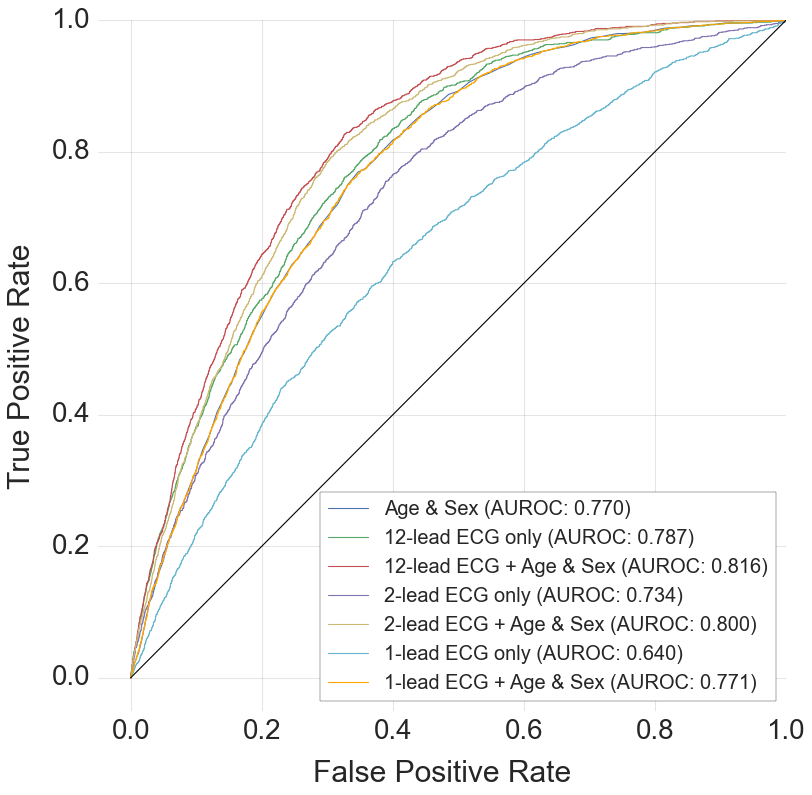

In [66]:
from pathlib import Path
import seaborn as sns

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(10.2, 10))
plt.rcParams['svg.fonttype'] = 'none'

softmax = nn.Softmax(dim=1)
useitem = allscores
rocs = [useitem.loc[i]['AUROC'].split(' ')[0] for i in useitem.index]
prcs = [useitem.loc[i]['AUPRC'].split(' ')[0] for i in useitem.index]

legend_list = [
    f'Age & Sex (AUROC: {rocs[0]})',
    f'12-lead ECG only (AUROC: {rocs[1]})',
    f'12-lead ECG + Age & Sex (AUROC: {rocs[2]})',
    f'2-lead ECG only (AUROC: {rocs[3]})',
    f'2-lead ECG + Age & Sex (AUROC: {rocs[4]})',
    f'1-lead ECG only (AUROC: {rocs[5]})',
    f'1-lead ECG + Age & Sex (AUROC: {rocs[6]})',
]

for n, (k, v) in enumerate(forgraph.items()):
    print(k)
    fpr, tpr, thresholds = roc_curve(v[1], softmax(torch.Tensor(v[0]))[:, 1].view(-1).cpu().detach().numpy())
    _precision, _recall, _ = precision_recall_curve(v[1], softmax(torch.Tensor(v[0]))[:, 1].view(-1).cpu().detach().numpy())
    if n != 6:
        ax1.plot(fpr, tpr, linewidth=1)
    else:
        ax1.plot(fpr, tpr, linewidth=1, color='orange')


ax1.patch.set_facecolor('white')
ax1.plot([0, 1], [0, 1], linewidth=1, color='black')
ax1.grid(color='black', alpha=.1)
ax1.set_xlabel('False Positive Rate', fontsize=27)
ax1.set_ylabel('True Positive Rate', fontsize=27)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.set_xlim(-0.05, 1)
ax1.set_ylim(-0.05, 1)
ax1.xaxis.set_label_coords(.5, -.07)
ax1.yaxis.set_label_coords(-.09, .5)
legend = plt.legend(legend_list, loc='lower right', frameon='True', fontsize=18)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('../results_figtable/roc.svg', format='svg')

demo
0_12_ecg_256
0_12_both_256
0_2_ecg_256
0_2_both_256
0_1_ecg_256
0_1_both_256


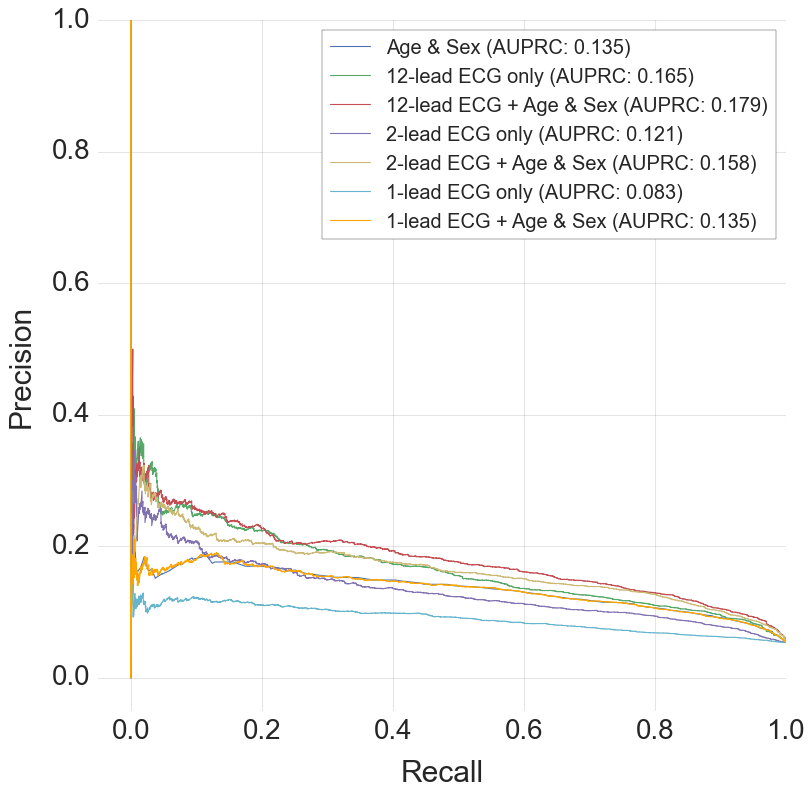

In [68]:
fig, ax1 = plt.subplots(figsize=(10.2, 10))
plt.rcParams['svg.fonttype'] = 'none'

useitem = allscores
rocs = [useitem.loc[i]['AUPRC'].split(' ')[0] for i in useitem.index]

legend_list = [
    f'Age & Sex (AUPRC: {rocs[0]})',
    f'12-lead ECG only (AUPRC: {rocs[1]})',
    f'12-lead ECG + Age & Sex (AUPRC: {rocs[2]})',
    f'2-lead ECG only (AUPRC: {rocs[3]})',
    f'2-lead ECG + Age & Sex (AUPRC: {rocs[4]})',
    f'1-lead ECG only (AUPRC: {rocs[5]})',
    f'1-lead ECG + Age & Sex (AUPRC: {rocs[6]})',
]

for n, (k, v) in enumerate(forgraph.items()):
    print(k)
    fpr, tpr, thresholds = roc_curve(v[1], softmax(torch.Tensor(v[0]))[:, 1].view(-1).cpu().detach().numpy())
    _precision, _recall, _ = precision_recall_curve(v[1], softmax(torch.Tensor(v[0]))[:, 1].view(-1).cpu().detach().numpy())

    if n != 6:
        ax1.plot(_recall, _precision, linewidth=1)
    else:
        ax1.plot(_recall, _precision, linewidth=1, color='orange')

ax1.patch.set_facecolor('white')
ax1.grid(color='black', alpha=.1)
ax1.set_xlabel('Recall', fontsize=27)
ax1.set_ylabel('Precision', fontsize=27)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.set_xlim(-0.05, 1)
ax1.set_ylim(-0.05, 1)
ax1.xaxis.set_label_coords(.5, -.07)
ax1.yaxis.set_label_coords(-.09, .5)
legend = plt.legend(legend_list, loc='upper right', fontsize=18, frameon='True')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('../results_figtable/prc.svg', format='svg')

# Grad CAM

In [66]:
from scipy import interpolate

test_loader = DataLoader(tds, batch_size=1, shuffle=True)
bw_loader = DataLoader(ds, batch_size=1, shuffle=True)

model = ResNet(fc_dim=256, lead=12)
svdpth = '/workspace/results/2048/diabetes/saved/'
file = '0_12_both_256'
device = 'cuda:3'
svdfile = 'best_supervised_model_54.tar'
softmax = nn.Softmax(dim=0)

model.to(device)
loadmodel = torch.load(os.path.join(svdpth, file, svdfile), map_location=device)
model.load_state_dict(loadmodel['model'])
model.eval()

import torch
import torch.nn as nn
import torch.nn.functional as F


class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.register_hooks()

    def register_hooks(self):
        for modue_name, module in self.model._modules.items():
            if modue_name == self.module:
                for layer_name, module in module._modules.items():
                    if layer_name == self.layer:
                        module.register_forward_hook(self.forward_hook)
                        module.register_backward_hook(self.backward_hook)

    def forward(self, input, demo, target_index):
        outs = self.model(input, demo, 'both')
        outs = outs.squeeze()  # [1, num_classes]  --> [num_classes]
        input.requires_grad = True
		
        # 가장 큰 값을 가지는 것을 target index 로 사용 
        if target_index is None:
            target_index = outs.argmax()

        outs[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1), keepdim=True)         # [512, 1, 1]
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()                  # [512, 7, 7] * [512, 1, 1]
        out = torch.relu(out) / torch.max(out)  # 음수를 없애고, 0 ~ 1 로 scaling # [7, 7]
        upsample = nn.Upsample(scale_factor=int(5000 / out.view(-1).shape[0]), mode='linear')
        # out = upsample(out.view(1, 1, 40))  
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward

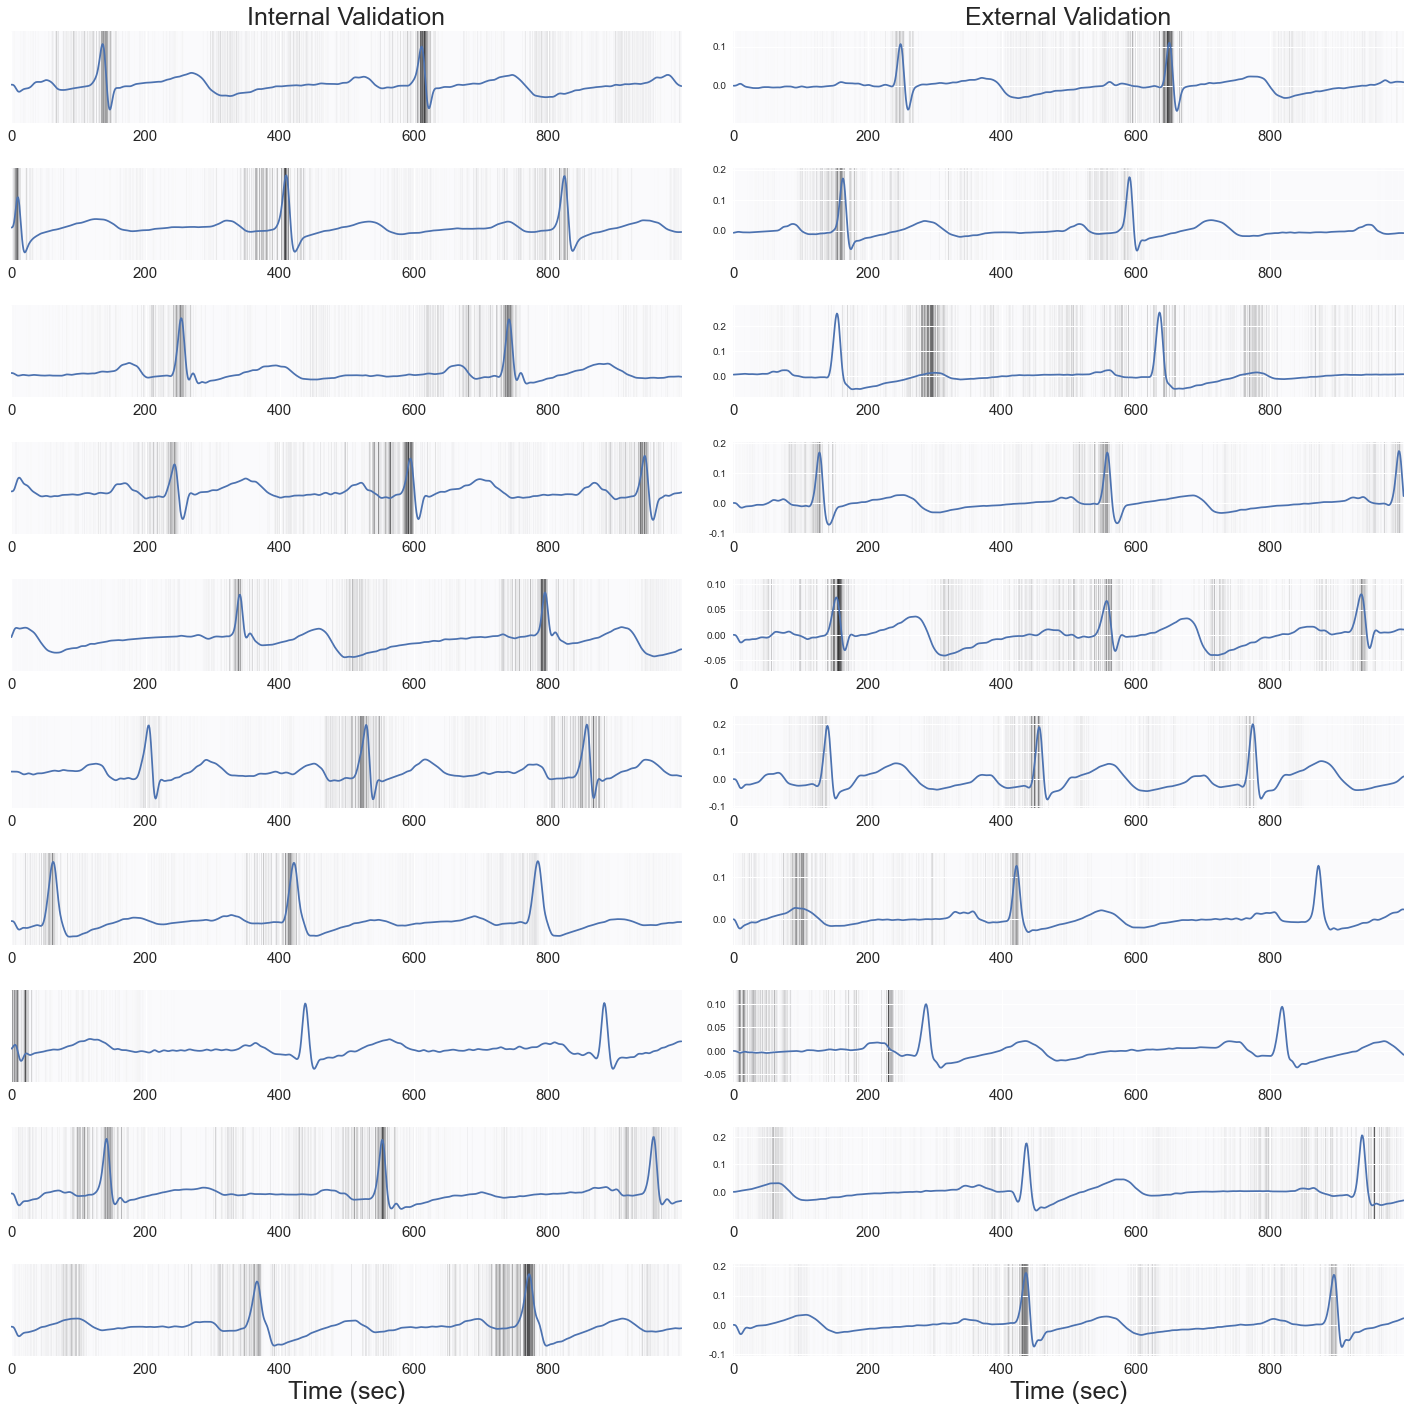

In [68]:
softmax = nn.Softmax(dim=1)
plt.figure(figsize=(20, 20))
grad_plots = {_n: plt.subplot(10, 2, _n*2+1) for _n in range(10)}
grad_plots2 = {_n: plt.subplot(10, 2, _n*2+2) for _n in range(10)}

for _n in range(10):
    for lead8, demo, flag in test_loader:        
        if flag.item() == 1:
            lead8 = lead8.type(torch.float32).to(device)
            demo = demo.type(torch.float32).to(device)
            target = flag.type(torch.LongTensor).to(device)
            lead8, demo = lead8[:1].view(-1, 12, 5000), demo[:1].view(-1, 2)

            ##################################################################### 1. Prepare Sample Data
            input = lead8
            input.requires_grad = True
            out = model(input, demo, 'both')
            if softmax(out)[0][1].item() < 0.048102: continue
            ##################################################################### 2. Guided Backpropagation
            out[:, 1].backward() 
            guided_back_ = input.grad    
            guided_back_ = F.relu(guided_back_) #/ torch.max(guided_back_)
            guided_back = guided_back_.cpu().numpy()
            # 0이상인 것만 남겨둔다면??

            # GradCAM 인스턴스 생성
            grad_cam = GradCam(model, module='resblock3', layer='4').to(device)  # GradCAM을 계산할 레이어 선택

            # 모델 실행 및 GradCAM 계산
            output = grad_cam.forward(lead8, demo, None)
            # print(output)
            dat_ = output.squeeze()
            # print('Gradcam shape (before interpolation) : ',dat_.shape)
            want_length = 5000
            x_ = np.arange(0,dat_.shape[0])
            x_new = np.arange(0,len(x_)-1,(len(x_)-1)/want_length)
            f = interpolate.interp1d(x_, dat_)
            gradcam = f(x_new)
            gradcam_expand = np.expand_dims(gradcam,axis=0)
            # print('Gradcam shape (after interpolation) :',gradcam.shape)
            gudied_gradcam=guided_back*gradcam

            if len(np.where(gudied_gradcam[0][1] != 0)[0]) == 0: continue
            start = np.where(gudied_gradcam[0][1] != 0)[0][0]

            plot_input = input[0][1][start:start+1000].cpu().detach().numpy()
            plot_gudied_gradcam = gudied_gradcam[0][1][start:start+1000]
            if _n == 0:
                grad_plots[_n].set_title("Internal Validation", fontsize=25)
            grad_plots[_n].plot(plot_input)
            grad_plots[_n].imshow([plot_gudied_gradcam],
                                    alpha=0.8, 
                                    # cmap='Reds',
                                    aspect='auto',
                                    vmin=np.min(plot_gudied_gradcam),
                                    vmax=np.max(plot_gudied_gradcam))
            grad_plots[_n].set_ylim([np.min(plot_input)-0.03, np.max(plot_input)+0.03])
            grad_plots[_n].tick_params(axis='x', labelsize=15)
            grad_plots[_n].set_yticks([])
            if _n == 9:
                grad_plots[_n].set_xlabel('Time (sec)', fontsize=25)
            break
        
for _n in range(10):
    for lead8, demo, flag in test_loader:        
        if flag.item() == 0:
            lead8 = lead8.type(torch.float32).to(device)
            demo = demo.type(torch.float32).to(device)
            target = flag.type(torch.LongTensor).to(device)
            lead8, demo = lead8[:1].view(-1, 12, 5000), demo[:1].view(-1, 2)

            ##################################################################### 1. Prepare Sample Data
            input = lead8
            input.requires_grad = True
            out = model(input, demo, 'both')
            if softmax(out)[0][1].item() < 0.048102: continue
            ##################################################################### 2. Guided Backpropagation
            out[:, 1].backward() 
            guided_back_ = input.grad    
            guided_back_ = F.relu(guided_back_) #/ torch.max(guided_back_)
            guided_back = guided_back_.cpu().numpy()
            # 0이상인 것만 남겨둔다면??

            # GradCAM 인스턴스 생성
            grad_cam = GradCam(model, module='resblock3', layer='4').to(device)  # GradCAM을 계산할 레이어 선택

            # 모델 실행 및 GradCAM 계산
            output = grad_cam.forward(lead8, demo, None)
            # print(output)
            dat_ = output.squeeze()
            # print('Gradcam shape (before interpolation) : ',dat_.shape)
            want_length = 5000
            x_ = np.arange(0,dat_.shape[0])
            x_new = np.arange(0,len(x_)-1,(len(x_)-1)/want_length)
            f = interpolate.interp1d(x_, dat_)
            gradcam = f(x_new)
            gradcam_expand = np.expand_dims(gradcam,axis=0)
            # print('Gradcam shape (after interpolation) :',gradcam.shape)
            gudied_gradcam=guided_back*gradcam

            if len(np.where(gudied_gradcam[0][1] != 0)[0]) == 0: continue
            start = np.where(gudied_gradcam[0][1] != 0)[0][0]

            plot_input = input[0][1][start:start+1000].cpu().detach().numpy()
            plot_gudied_gradcam = gudied_gradcam[0][1][start:start+1000]
            if _n == 0:
                grad_plots2[_n].set_title("External Validation", fontsize=25)
            grad_plots2[_n].plot(plot_input)
            grad_plots2[_n].imshow([plot_gudied_gradcam],
                                    alpha=0.8, 
                                    # cmap='Reds',
                                    aspect='auto',
                                    vmin=np.min(plot_gudied_gradcam),
                                    vmax=np.max(plot_gudied_gradcam))
            grad_plots2[_n].set_ylim([np.min(plot_input)-0.03, np.max(plot_input)+0.03])
            grad_plots2[_n].tick_params(axis='x', labelsize=15)
            grad_plots[_n].set_yticks([])
            if _n == 9:
                grad_plots2[_n].set_xlabel('Time (sec)', fontsize=25)
            break
        
plt.tight_layout()
# plt.savefig('../results_figtable/gradcam.svg', format='svg')

P value: 1.230407432164249e-09
Missed: 9497 / Normal: 17773


,report,p
covariate,,
Model classification,1.67 (1.41-1.96),0.0000
Age,1.01 (1.01-1.02),0.0003
Sex,1.17 (1.01-1.36),0.0349
Glucose,1.04 (1.03-1.05),0.0000
HbA1c,4.31 (3.41-5.45),0.0000
Malignant tumor,2.53 (0.81-7.84),0.1090
Peptic ulcer disease,1.02 (0.20-5.34),0.9786
Cerebrovascular disease,0.52 (0.04-7.71),0.6345
Connective tissue disease,0.76 (0.01-92.24),0.9089


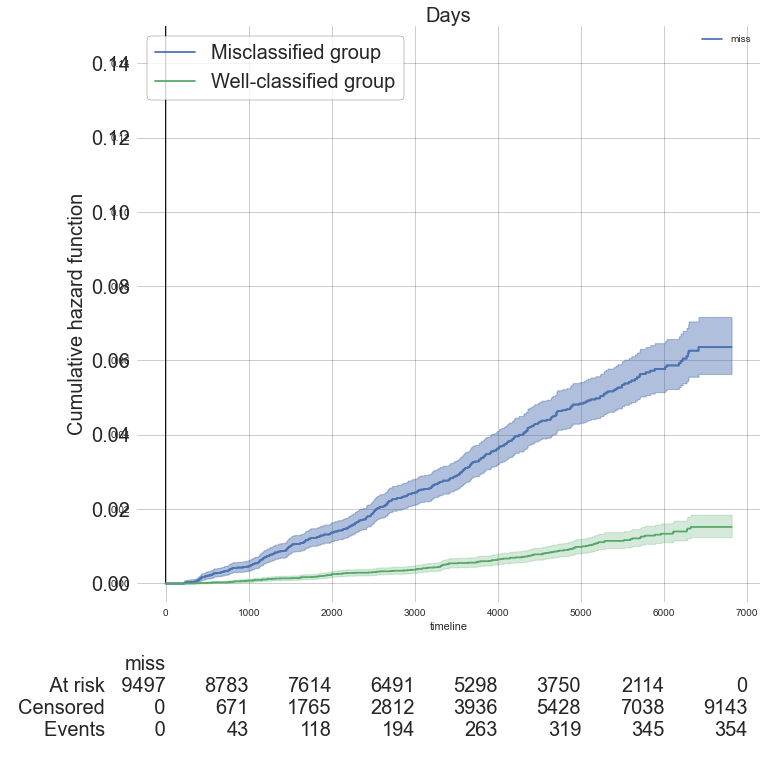

In [32]:
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

with open('../results_figtable/allscores.pkl', 'rb') as f:
    cci, allscores, allscores_bd_norefit, forgraph, forgraph_bd, testgn, bw = pickle.load(f)

plt.rcParams['axes.unicode_minus'] = False
# plt.style.use('seaborn')

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot()
ax1.patch.set_facecolor('white')
d0 = testgn[testgn['diabetes_flag'] == 0]
# d0 = bw[bw['diabetes_flag'] == 0]
info = cci[cci['disease'] == 'diabetes'][['PT_NO', '진단일자']]
info.columns = ['PT_NO', 'd_date']
info['Event'] = 1
info['d_date'] = pd.to_datetime(info['d_date'])
info['PT_NO'] = info['PT_NO'].astype(str)
i1 = info

dimerge = pd.merge(d0, i1, on='PT_NO', how='left')
dimerge['d_date'] = dimerge['d_date'].fillna(pd.to_datetime('2023-06-12'))
dimerge['Event'] = dimerge['Event'].fillna(0)
dimerge['Time'] = (pd.to_datetime(dimerge['d_date']) - pd.to_datetime(dimerge['date'])).dt.days
dimerge = dimerge[dimerge['Time'] >= 180]
dimerge['gender'] = dimerge['gender'].apply(lambda x: 1 if x == 'MALE' else 0)

ccis = ['malignancy', 'ulcer', 'cerebrovascular', 'connective',
       'MI', 'pulmonary', 'liver']
# ccis = ['liver', 'MI', 'cerebrovascular',
#        'peripheral', 'ulcer', 'malignancy', 'metastatic', 'pulmonary', 'renal',
#        'connective', 'dementia']

usedat = dimerge.copy()
# usedat = usedat[(usedat['glucose'] < 110) & (usedat['hba1c'] < 5.6)].reset_index(drop=True)
forcph = usedat[['diabetes_pred', 'age', 'gender', 'Time', 'Event', 'glucose', 'hba1c'] + ccis]
forcph['Event'] = forcph['Event'].astype(int)
forcph.columns = [
    'Model classification',
    'Age',
    'Sex',
    'Time',
    'Event',
    'Glucose',
    'HbA1c',
    'Malignant tumor',
    'Peptic ulcer disease',
    'Cerebrovascular disease',
    'Connective tissue disease',
    'Myocardial infarction',
    'Pulmonary disease',
    'Liver disease',
    ]


cph = CoxPHFitter(penalizer=0.01)
cph.fit(forcph, "Time", event_col="Event")
pv = cph.summary['p']['Model classification']
print(f'P value: {pv}')

kmf1 = NelsonAalenFitter()
kmf2 = NelsonAalenFitter()

miss = forcph[forcph['Model classification'] == 1]
nomiss = forcph[forcph['Model classification'] != 1]
print(f'Missed: {miss.shape[0]} / Normal: {nomiss.shape[0]}')

T = miss['Time']
E = miss['Event'].astype(int)
kmf1.fit(T, E, label='miss')

T = nomiss['Time']
E = nomiss['Event'].astype(int)
kmf2.fit(T, E, label='nomiss')


ax1.patch.set_facecolor('white')
ax1.plot([0, 1], [0, 1], linewidth=1, color='black')
ax1.grid(color='black', alpha=.1)
curve1 = kmf1.plot_cumulative_hazard(at_risk_counts=True)
curve1 = kmf1.plot_cumulative_hazard()
curve2 = kmf2.plot_cumulative_hazard()

plt.xlabel('Days', fontsize=20)
plt.ylabel('Cumulative hazard function', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
legend = plt.legend(['Misclassified group', 'Well-classified group'], loc='upper left', fontsize=20, frameon='True')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
plt.ylim([-0.005, 0.15])
plt.grid(color='black', alpha=.1)

cs = cph.summary
cs['report'] = cs.apply(lambda x: f'{r2(x["exp(coef)"])} ({r2(x["exp(coef) lower 95%"])}-{r2(x["exp(coef) upper 95%"])})', axis=1)
cs['p'] = cs['p'].apply(lambda x: r4(x))
cs[['report', 'p']]